In [137]:
import math
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import matplotlib.backends.backend_pdf as plt_bc

In [141]:
def rounddown(x):
     return int(math.ceil(x / 100.0)) * 100 - 100

def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

def get_column_from_many_csv(filenames, col_num):
    intermediate_df = pd.DataFrame()
    for i, path in enumerate(filenames):
        df = pd.read_csv(path, skiprows=1)
        intermediate_df[i] = df.iloc[:, col_num]
    return intermediate_df

In [3]:
def smoothen_plot(x, y, smooth_power=300):
    smoothened_x = np.linspace(x.min(), x.max(), smooth_power)
    spl = make_interp_spline(x, y, k=3)
    smoothened_y = spl(smoothened_x)
    return smoothened_x, smoothened_y

In [159]:
def create_plot_ac_u_comp(df, cumulative=False, plot_title="", clean=3, smooth_u=0, smooth_ac=0, draw_v_lines=False):
    if clean:
        cleaned_df = removed_outliers(df, 'ac_iter_time', level=clean)
        cleaned_df = removed_outliers(cleaned_df, 'norm_iter_time', level=clean)
        cleaned_df.reset_index(drop=True, inplace=True)
    else:
        cleaned_df = df

    fig, ax = plt.subplots(figsize=(15, 5))
    if plot_title:
        ax.set_title(plot_title)

    ax.set_xlabel('Iteration')
    if cumulative:
        ax.set_ylabel('Elapsed time [s]')
        cleaned_df.ac_iter_time = cleaned_df.ac_iter_time / (10 ** 9)
        cleaned_df.norm_iter_time = cleaned_df.norm_iter_time / (10 ** 9)
    else:
        ax.set_ylabel('Time of 10 iterations [ms]')
        cleaned_df.ac_iter_time = cleaned_df.ac_iter_time / (10 ** 6)
        cleaned_df.norm_iter_time = cleaned_df.norm_iter_time / (10 ** 6)

    print(cleaned_df.norm_iter_time)
    if smooth_ac:
        new_iter_no, ac_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, smooth_ac)
    else:
        new_iter_no, ac_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.ac_iter_time

    ax.plot(new_iter_no, ac_iter_time_smooth, label='Active cells', c='black', ls='-.')

    if smooth_u:
        new_iter_no, norm_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.norm_iter_time, smooth_u)
    else:
        new_iter_no, norm_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.norm_iter_time

    ax.plot(new_iter_no, norm_iter_time_smooth, label='Non-active cells', c='black', ls=':')

    iteration_no = cleaned_df['iteration_no']

    cross_point = ((cleaned_df['ac_iter_time'] - cleaned_df['norm_iter_time']).abs()).idxmin()
    if draw_v_lines:
        ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()
        ax.text(iteration_no[cross_point] - x_lim[1] * .01,
                (y_lim[1] - y_lim[0]) * .02 + y_lim[0],
                'Iteration time crossover', rotation=90)

    xs = (
      list(range(0, cleaned_df.shape[0], round(cleaned_df.shape[0] / 6)))
      + [cross_point, len(cleaned_df) - 1]
    )
    xticks = [iteration_no[i]  for i in xs]


    ax.set_xticks([rounddown(i) for i in xticks])

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA')

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0] * 100:.0f}%'
        for i in xticks
    ])

    plt.legend()
    return fig

### Averaged results (100)

In [161]:
def read_averaging_data(ac_glob, normal_glob):
    ac_to_avg = glob(ac_glob)
    normal_to_avg = glob(normal_glob)

    avg_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time', 'x', 'y'])
    avg_comp.drop(['x', 'y'], axis=1, inplace=True)

    avg_comp['ac_iter_time'] = get_column_from_many_csv(ac_to_avg, 2).median(axis=1)
    avg_comp['norm_iter_time'] = get_column_from_many_csv(normal_to_avg, 2).median(axis=1)

    avg_comp.describe()
    return avg_comp

In [152]:
def cumulate_data(data):
    data['ac_iter_time']=data["ac_iter_time"].cumsum()
    data['norm_iter_time']=data["norm_iter_time"].cumsum()
    return data

def create_test_plot(test_dir, size, data_dir="results/final", clean=False, memory="g",cumulative=False):
    data_path = f"{data_dir}/{test_dir}"
    data = read_averaging_data(f"{data_path}/ac_{memory}*{size}*/*1[1-9]*",f"{data_path}/{memory}*{size}*/*")

    plot_title = f"{test_dir.replace('_',' ').title()} Memory: {memory.capitalize()}, Size: {size}x{size} "
    if clean:
        plot_title = f"{plot_title} Clean: {clean}"

    if cumulative:
        plot_title = f"{plot_title} Cumulative"
        data = cumulate_data(data)
    create_plot_ac_u_comp(data, cumulative=cumulative, clean=clean, plot_title=plot_title)

In [7]:
def save_all_plots(file_name):
    pdf = plt_bc.PdfPages(f"{file_name}.pdf")
    for fig in range(1, plt.gcf().number + 1):
        pdf.savefig( fig )
    pdf.close()

In [157]:
def create_all_averaging_plots(test_dir, memory):
    create_test_plot(test_dir=test_dir, size=4000, memory=memory)
    create_test_plot(test_dir=test_dir, size=4000, cumulative=True, memory=memory)
    create_test_plot(test_dir=test_dir, size=6000, memory=memory)
    create_test_plot(test_dir=test_dir, size=6000, cumulative=True, memory=memory)

0      29.861900
1      29.501143
2      28.553060
3      27.225488
4      27.194324
         ...    
495          NaN
496          NaN
497          NaN
498          NaN
499          NaN
Name: norm_iter_time, Length: 500, dtype: float64
0      0.029862
1      0.059363
2      0.087916
3      0.115142
4      0.142336
         ...   
495         NaN
496         NaN
497         NaN
498         NaN
499         NaN
Name: norm_iter_time, Length: 500, dtype: float64
0      62.871960
1      61.904856
2      64.305298
3      67.089434
4      68.899094
         ...    
495    52.636179
496    52.634530
497    52.638410
498    52.643366
499          NaN
Name: norm_iter_time, Length: 500, dtype: float64
0       0.062872
1       0.124777
2       0.189082
3       0.256172
4       0.325071
         ...    
495    29.499404
496    29.552039
497    29.604677
498    29.657320
499          NaN
Name: norm_iter_time, Length: 500, dtype: float64
0      622.127319
1      639.310998
2      655.164210
3      67

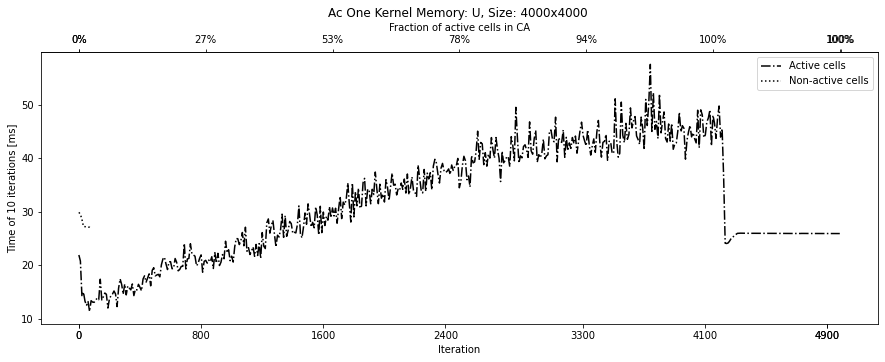

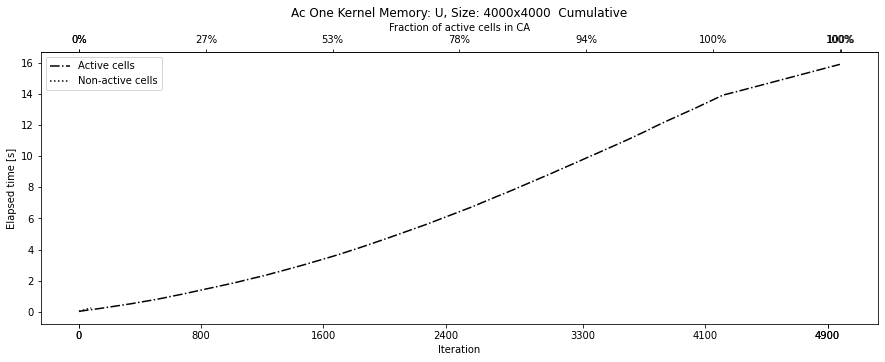

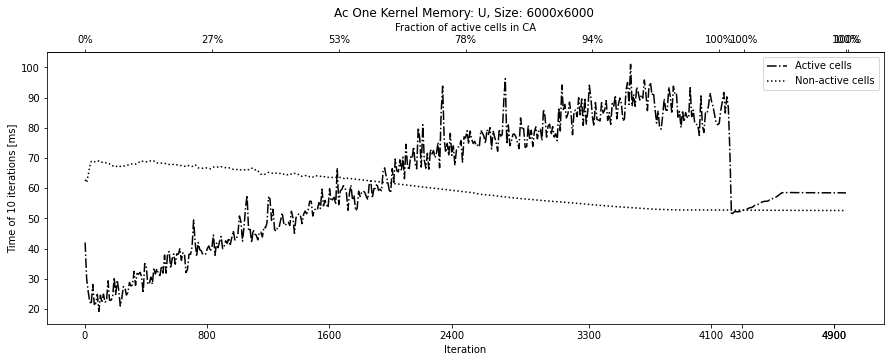

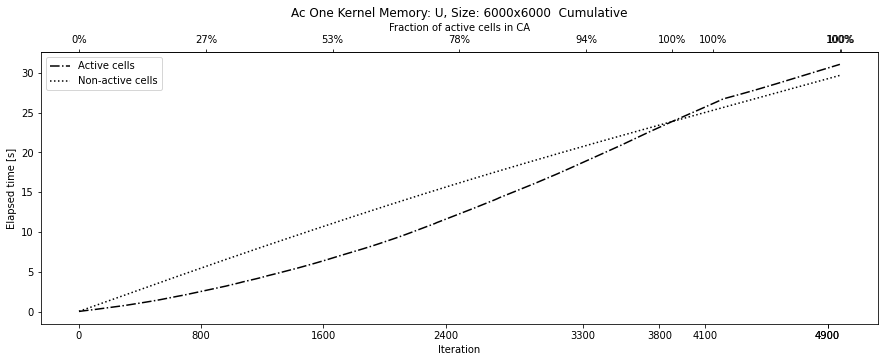

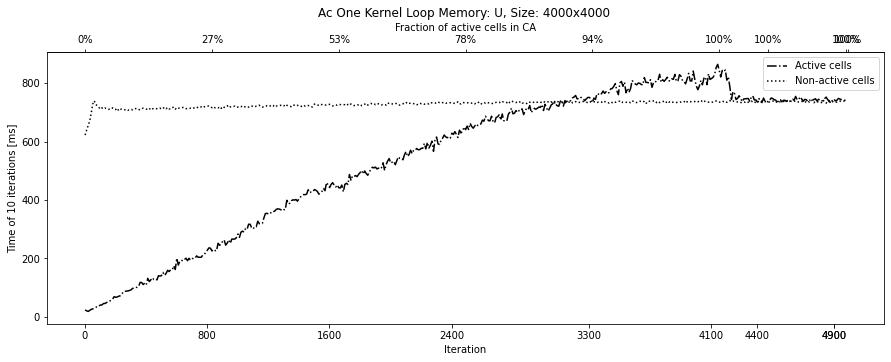

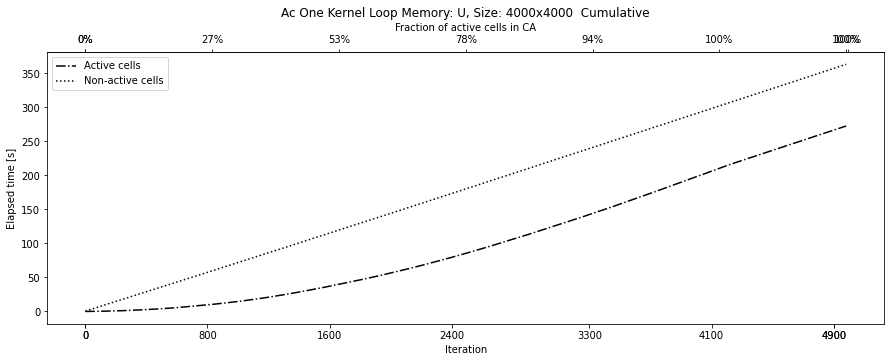

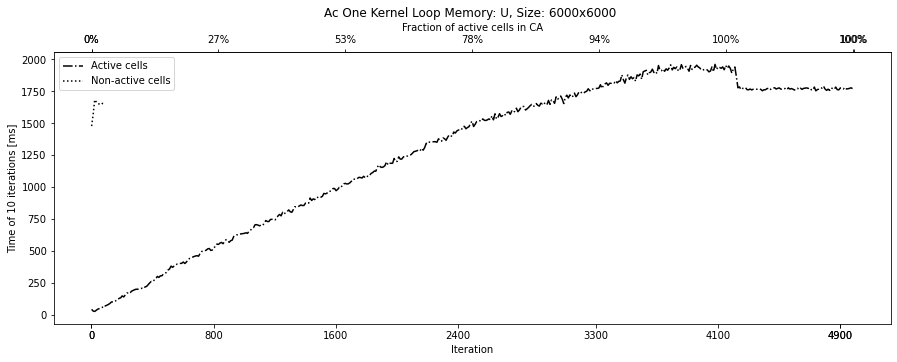

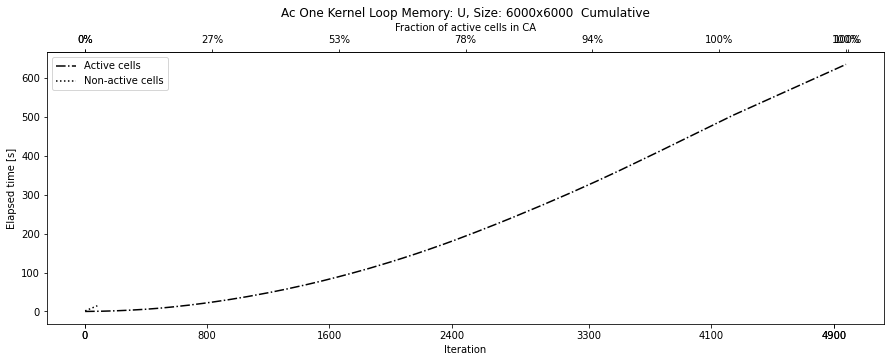

In [162]:
create_all_averaging_plots(test_dir="ac_one_kernel", memory="u")
create_all_averaging_plots(test_dir="ac_one_kernel_loop", memory="u")
save_all_plots("threshold")

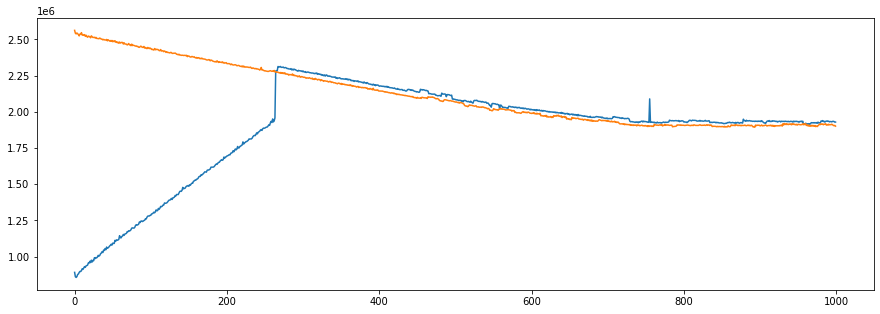

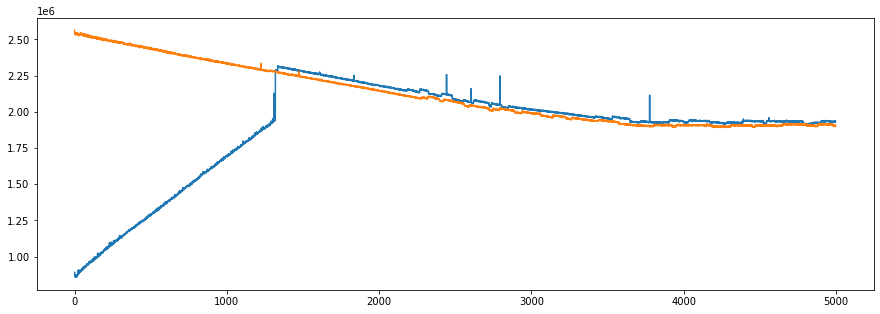

In [127]:
_, ax = plt.subplots(figsize=(15, 5))
unified_iter_time = get_column_from_many_csv(glob("results/final/ac_threshold/u_standard_4000_5000_8_0_1_1/*"), 2).min(axis=1)
ac_iter_time = get_column_from_many_csv(glob("results/final/ac_threshold/ac_u_standard_threshold_4000_5000_8_0_1_1/*"), 2).median(axis=1)
aa = pd.DataFrame()
aa["ac_iter_time"]=ac_iter_time
aa["u_iter_time"]=unified_iter_time
_, ac_iter_time_smooth = smoothen_plot(pd.Series(range(0,len(ac_iter_time))), ac_iter_time, smooth_power=1000)
_, unified_iter_time_smooth = smoothen_plot(pd.Series(range(0,len(unified_iter_time))), unified_iter_time, smooth_power=1000)


ax.plot(ac_iter_time_smooth)
ax.plot(unified_iter_time_smooth)

_, ax2 = plt.subplots(figsize=(15, 5))
ax2.plot(ac_iter_time)
ax2.plot(unified_iter_time)

### Crossover

In [11]:
crossover_ac = sorted(glob('unical_mount_point/coverage_tests/active_cells_*'))
ca_sizes = sorted(set(filepath.split('_')[-6] for filepath in crossover_ac))

active_cell_cols = ['iteration_no', 'ac_coverage', 'ac_iter_time', 'ac_trans_time', 'ac_find_time']
crossovers = dict()

for ca_size in ca_sizes:
    crossover_ac = sorted(glob(f'unical_mount_point/coverage_tests/active_cells_32_{ca_size}*'))
    crossover_u = sorted(glob(f'unical_mount_point/coverage_tests/unified_memory_32_{ca_size}*'))

    avg_crossover_df = pd.DataFrame()
    avg_crossover_df['ac_iter_time'] = get_column_from_many_csv(crossover_ac, 2).quantile([.25], axis=1).T.iloc[:,0]
    avg_crossover_df['ac_coverage'] = pd.read_csv(crossover_ac[0], skiprows=1, names=active_cell_cols).ac_coverage
    avg_crossover_df['u_iter_time'] = get_column_from_many_csv(crossover_u, 2).quantile([.25], axis=1).T.iloc[:,0]

    crossover_idx = ((avg_crossover_df.ac_iter_time - avg_crossover_df.u_iter_time) >= 0).iloc[300:].idxmax()

    coverage = avg_crossover_df.ac_coverage.iloc[crossover_idx]

    crossovers[ca_size] = coverage
crossovers

{}

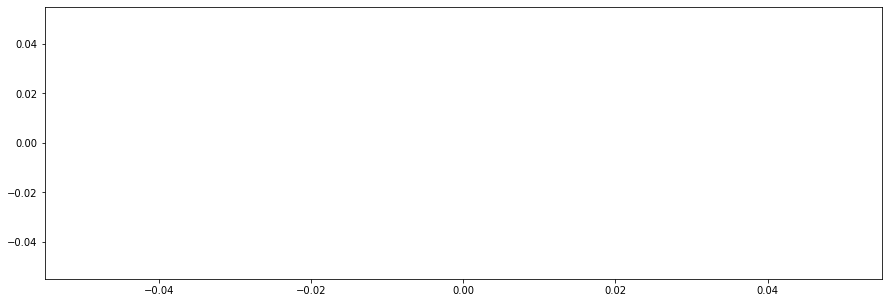

In [12]:
_, ax = plt.subplots(figsize=(15, 5))
ax.plot(list(crossovers.keys()), list(crossovers.values()))

In [13]:
crossover_ac = sorted(glob('unical_mount_point/coverage_tests/active_cells_*'))
ca_sizes = sorted(set(filepath.split('_')[-6] for filepath in crossover_ac))

active_cell_cols = ['iteration_no', 'ac_coverage', 'ac_iter_time', 'ac_trans_time', 'ac_find_time']
quantiles = np.array(range(0, 101, 10)) / 100
covers_all = {q: dict() for q in quantiles}

for ca_size in ca_sizes:
    crossover_ac = sorted(glob(f'unical_mount_point/coverage_tests/active_cells_32_{ca_size}*'))
    crossover_u = sorted(glob(f'unical_mount_point/coverage_tests/unified_memory_32_{ca_size}*'))

    ac_df = get_column_from_many_csv(crossover_ac, 2).quantile(quantiles, axis=1).T
    u_df = get_column_from_many_csv(crossover_u, 2).quantile(quantiles, axis=1).T
    for i, quantile in enumerate(quantiles):

        avg_crossover_df = pd.DataFrame()
        avg_crossover_df['ac_coverage'] = pd.read_csv(crossover_ac[0], skiprows=1, names=active_cell_cols).ac_coverage
        avg_crossover_df['ac_iter_time'] = ac_df.iloc[:, i]
        avg_crossover_df['u_iter_time'] = u_df.iloc[:, i]

        crossover_idx = ((avg_crossover_df.ac_iter_time - avg_crossover_df.u_iter_time) >= 0).iloc[300:].idxmax()
        coverage = avg_crossover_df.ac_coverage.iloc[crossover_idx].copy()

        covers_all[quantile][ca_size] = coverage * 100
covers_all

{0.0: {},
 0.1: {},
 0.2: {},
 0.3: {},
 0.4: {},
 0.5: {},
 0.6: {},
 0.7: {},
 0.8: {},
 0.9: {},
 1.0: {}}

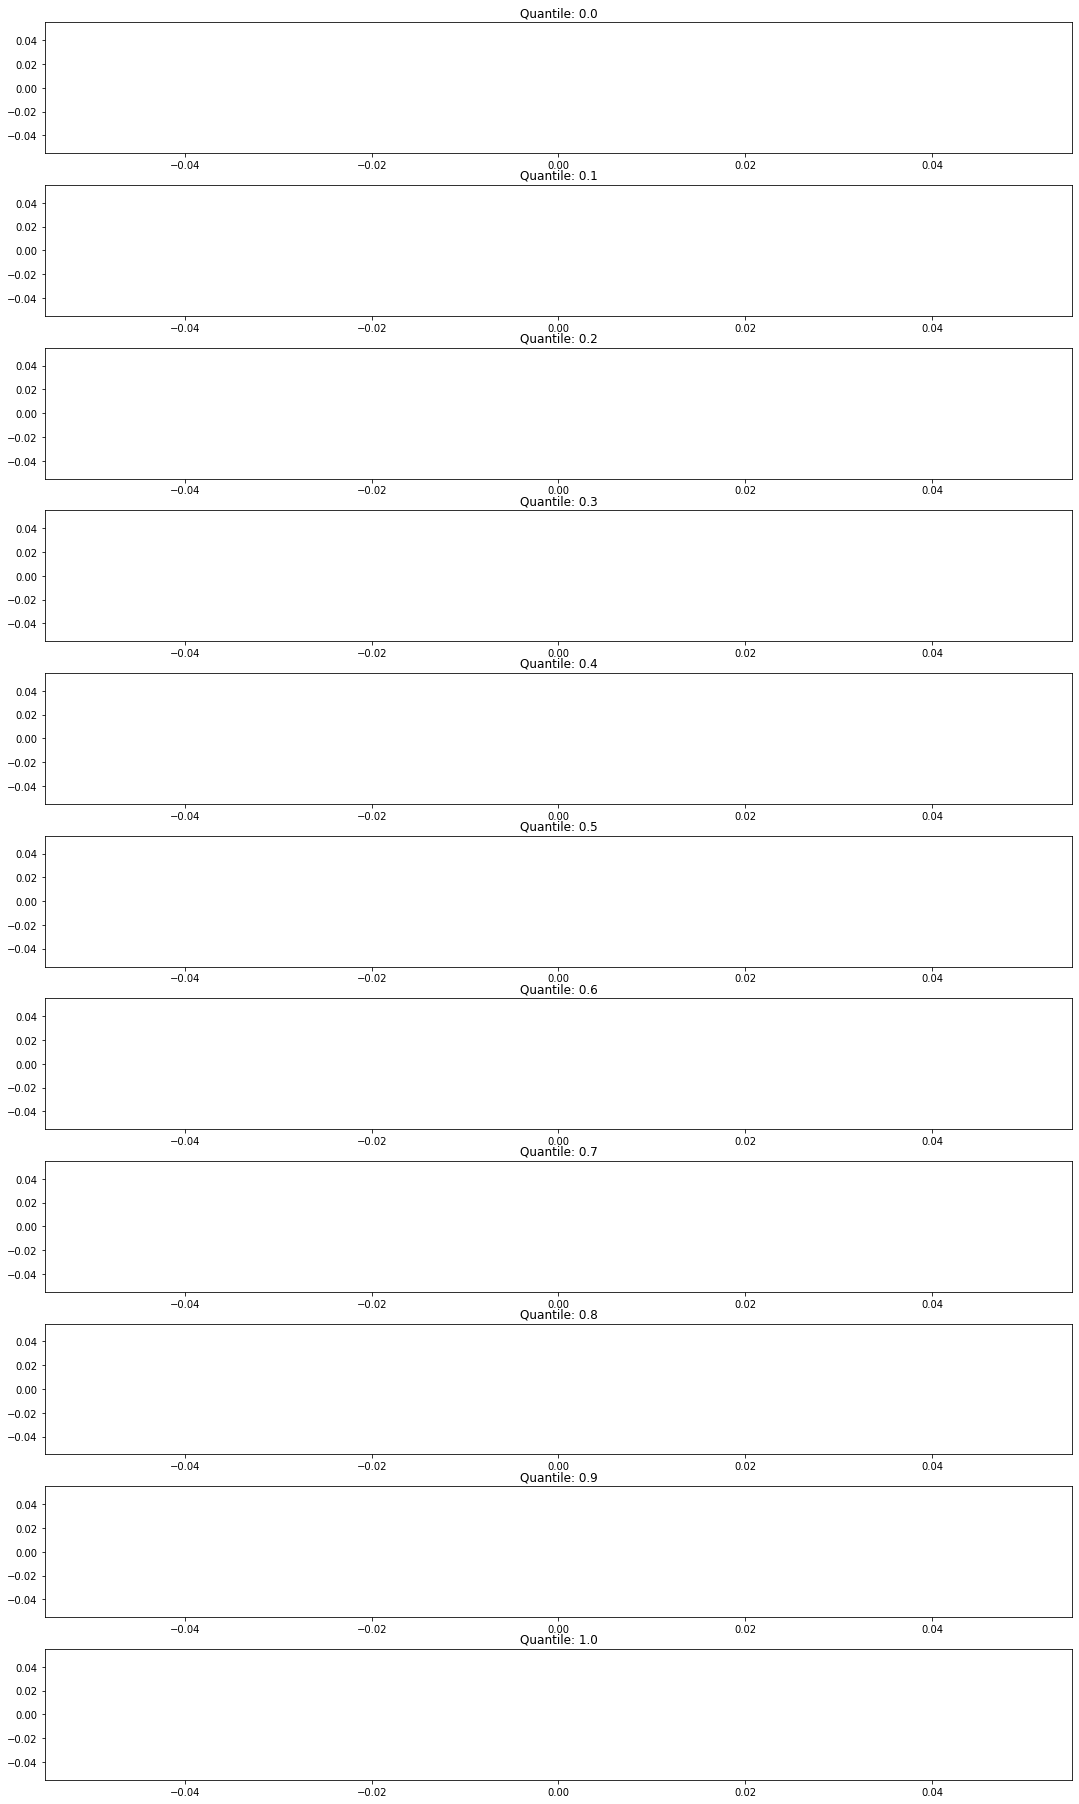

In [14]:
f, axes = plt.subplots(nrows=len(quantiles), figsize=(15, 25))
f.tight_layout()
for ax, (quantile, covers) in zip(axes, covers_all.items()):
    ax.set_title(f'Quantile: {quantile}')
    ax.plot(list(covers.keys()), list(covers.values()))